# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.io import loadmat
from numpy import linalg as la
# from scipy.optimize import curve_fit
from scipy import ndimage

%matplotlib inline

In [2]:
import import_ipynb
os.chdir('Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
from StimulusnResponse import SSG
from Spike_Generation import SG
from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def NGD3L1D_STK(xAxis, tAxis, sigma_dict, tPara_ict, spaceDivideStep = 1, timeDivideStep = 60):
# divideStep upsample rate
# tPara_dict must include these temporal parameters: alpha, beta, gamma, g, h, l 
    dx = np.mean(np.diff(xAxis)) / spaceDivideStep
    xAxis = AxisByHalfLen(xAxis[-1], dx)
    gaussK = {} # Gassian Kernel
    for (key,value) in sigma_dict.items():
        halfKLen = min( value*8, xAxis[-1])
        kAxis = AxisByHalfLen(halfKLen, dx)
        gaussK[key] = Gaussian_filter_1d(kAxis,value)

    dt = np.mean(np.diff(tAxis)) / timeDivideStep
    tAxis = np.arange(0, tAxis[-1]+dt, dt)
    stimulus = np.zeros([len(tAxis), len(xAxis)])
    if "tau_delay" in tPara_ict:
        delayed_delta = tAxis /tPara_dict['tau_delay']/tPara_dict['tau_delay'] *np.exp(-tAxis/tPara_dict['tau_delay']) *dt
        stimulus[:,int(len(xAxis)/2)] = delayed_delta
    else:
        stimulus[0,int(len(xAxis)/2)] = 1

    for key in ['alpha','beta','gamma','m','n','g','h','l']: # initialize tPara_ict
        if not key in tPara_ict.keys(): 
            tPara_ict[key] = 1

    z = np.zeros_like(stimulus)
    y = np.zeros_like(stimulus)
    w = np.zeros_like(stimulus)

    for i in np.arange(len(tAxis)-1):
        R = {'s2y':stimulus[i,:], 'y2z':y[i,:], 'y2w':y[i,:], 'z2y':z[i,:], 'z2w':z[i,:]} # initialization
        for key in R.keys():
            if key in gaussK:    R[key] = np.convolve(R[key],gaussK[key],'same')*dx

        dy = (-tPara_dict['alpha']*y[i,:] + tPara_dict['m']*R['s2y'] - tPara_dict['n']*R['z2y'])*dt
        dz = (-tPara_dict['beta'] *z[i,:] + tPara_dict['g']*R['y2z']                           )*dt
        dw = (-tPara_dict['gamma']*w[i,:] + tPara_dict['h']*R['y2w'] - tPara_dict['l']*R['z2w'])*dt

        y[i+1,:] = (y[i,:]+dy)
        z[i+1,:] = (z[i,:]+dz)
        w[i+1,:] = (w[i,:]+dw)
    actual_xAxisIndex = np.append( np.arange(int(len(xAxis)/2), -1, -spaceDivideStep)[:0:-1], np.arange(int(len(xAxis)/2), len(xAxis), spaceDivideStep) )
    y = y[::timeDivideStep, actual_xAxisIndex]/dx/dt #
    z = z[::timeDivideStep, actual_xAxisIndex]/dx/dt
    w = w[::timeDivideStep, actual_xAxisIndex]/dx/dt

    return w, z, y

def AxisByHalfLen(halfLen, dx):
    axis = np.arange(0, halfLen+dx, dx)
    return np.append(-1*axis[:0:-1], axis)


In [4]:
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Set Parameter

## Exp

In [5]:
# temporal
dt = 0.01 #large dt will cause  overflow
Tstep = int(1./dt)
TKtaxis = np.arange(Tstep)*dt

tPara_dict = {
'alpha':1.302408,
'beta':13.024075,
'gamma':34.901452,
'g':460.016331,
'l':0.021331,
'tau_delay':0.028650,
'm':127.832600} # m can be nagative for off cell

# spatial
sigma_dict = dict()
sigma_dict['y2w'] = 0.20426678569344126 *1.1 # mm from exp data (RF radius = 1.5*sigma)
sigma_dict['z2w'] = 1.1*sigma_dict['y2w'] 
sigma_dict['y2z'] = 0.05*sigma_dict['y2w']   # has to be small enough

dx = 0.005 # OLED pixel2micro = 7.6
hXstep =  int(2 /dx) # Half length of xais, (mm)
SKxaxis = np.arange(-hXstep,hXstep+1)*dx

## By hand

In [6]:
# # temporal
# dt = 0.01 #large dt will cause  overflow
# Tstep = int(1./dt)
# TKtaxis = np.arange(Tstep)*dt

# tPara_dict = {
# 'alpha':40,
# 'beta':2,
# 'gamma':100,
# 'm':40,
# 'n':200,
# 'g':2,
# 'h':50,
# 'l':50,
# 'tau_delay':0.02} # m can be nagative for off cell

# # spatial
# sigma_dict = dict()
# sigma_dict['y2w'] = 0.20426678569344126 *1.1 # mm from exp data (RF radius = 1.5*sigma)
# # sigma_dict['y2z'] =10/9*sigma_dict['y2w'] 
# sigma_dict['z2w'] = 1.1*sigma_dict['y2w'] 

# dx = 0.005 # OLED pixel2micro = 7.6
# hXstep =  int(2 /dx) # Half length of xais, (mm)
# # hXstep =  int(1.015 /dx) # range of Checkboard, 1.5*sqrt(2)/2
# SKxaxis = np.arange(-hXstep,hXstep+1)*dx

# STK

In [7]:
Delta_output_w, zts, Delta_output_y = NGD3L1D_STK(SKxaxis, TKtaxis, sigma_dict, tPara_dict)

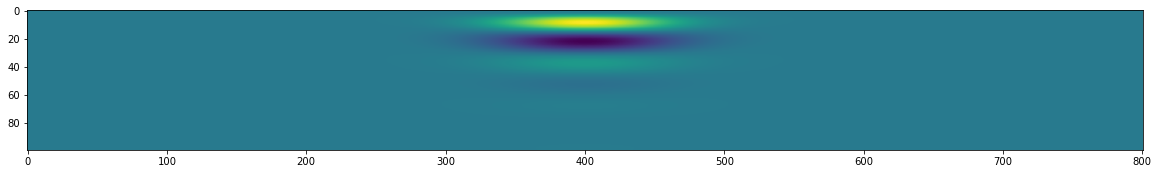

In [8]:
plt.imshow(Delta_output_w)
plt.gcf().set_size_inches(20, 5)


In [9]:
delSTK = Delta_output_w

In [10]:
iSK = np.sum(delSTK, axis = 0)*dt
iTK = np.sum(delSTK, axis = 1)*dx
SeSTK = iTK[:, np.newaxis]*iSK[np.newaxis, :]
mag_Se2del = 1/np.max(SeSTK)*np.max(delSTK)
SeSTK = SeSTK*mag_Se2del

# SVD

In [11]:
U,sigma,VT=la.svd(delSTK)

In [12]:
print((sigma/sum(sigma))[:5])
for i in range(2):
    if U[2,i] <0:
        VT[i,:] = -VT[i,:]
        U[:,i] = -U[:,i]
        

SVDSTK = U[:,0][:, np.newaxis]*VT[0,:][np.newaxis, :]*sigma[0]

[9.61498634e-01 3.84461338e-02 5.38562577e-05 1.36575741e-06
 9.63243521e-09]


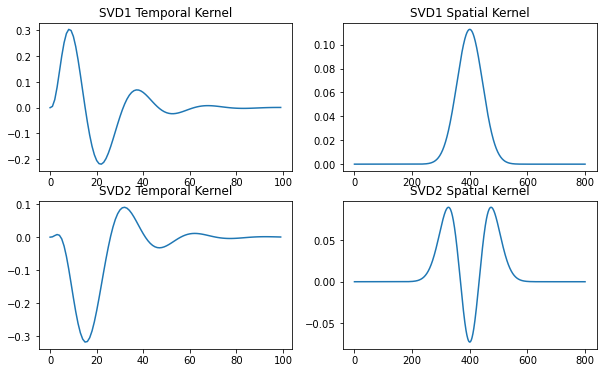

In [13]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(10, 6)

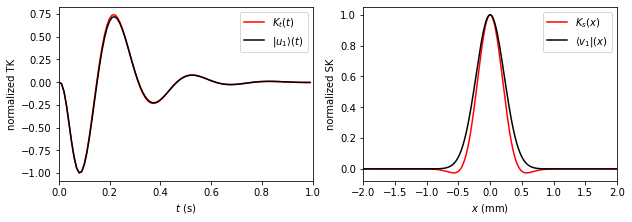

In [14]:
fig, ax = plt.subplots(1,2)
ax[1].plot(SKxaxis, iSK/np.max(iSK), 'r',label=r'$K_s(x)$')
ax[1].plot(SKxaxis, VT[0,:]/np.max(VT[0,:]), 'k',label=r'$\left\langle {v_1} \right|(x)$')
# ax[1].plot(SKxaxis, delSTK[np.where(delSTK == np.max(delSTK))[0][0], :]/np.max(delSTK), 'g--',label=r'$K_{st}(\arg\min_{t} K_{st}, x)$')
ax[1].legend(loc='best')
ax[1].set_ylabel('normalized SK')
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_xlim([-2,2])

ax[0].plot(TKtaxis, -iTK/np.max(iTK), 'r',label=r'$K_t(t)$')
ax[0].plot(TKtaxis, -U[:,0]/np.max(U[:,0]), 'k', label=r'$\left| u_1 \right\rangle(t)$')
# ax[0].plot(TKtaxis, -delSTK[:, np.where(delSTK == np.max(delSTK))[1][0]]/np.max(delSTK), 'g--',label=r'$K_{st}(t, \arg\min_{x} K_{st})$')
ax[0].set_xlabel(r'$t$ (s)')
ax[0].set_ylabel('normalized TK')
ax[0].set_xlim([0,1])
# ax[0].plot(TKtaxis, U[:,1]/np.max(U[:,1]) *sigma[1]/sigma[0], label='u2')

ax[0].legend(loc='best')
fig.set_size_inches(10,3.2)

Text(0.5, 1.0, 'group delay')

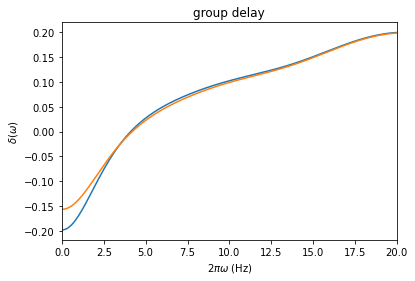

In [15]:
df = 0.1
faxis = np.arange(-50,50,df)

F_TK = np.sum(iTK[np.newaxis,:]*np.exp(-1j*TKtaxis[np.newaxis,:]*faxis[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/df
plt.plot(faxis, delta)
F_TK = np.sum(U[:,0][np.newaxis,:]*np.exp(-1j*TKtaxis[np.newaxis,:]*faxis[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/df
plt.plot(faxis, delta)
plt.ylabel(r'$\delta(\omega)$')
plt.xlabel(r'2$\pi\omega$ (Hz)')
plt.xlim([0,20])
plt.title('group delay')

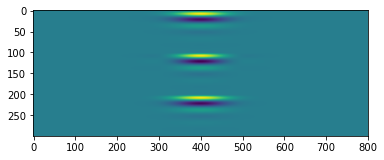

In [16]:
plt.imshow(np.vstack((delSTK,SeSTK,SVDSTK)))

# WF(LPOU)+GC

In [17]:
DR = 1.4 #mm
dDR = int(DR/dx+0.5)

Tto = 300
LPOUtaxis = np.arange(0,Tto,dt)
# Fc_list = np.array([0.5,1,2,4])
LPOU = SSG([1], dt, Tto, tau = 1, D = 1)[0]

contrast = 2
mean_list = [2,10,30,100];
sti_list = [(LPOU-np.mean(LPOU))/np.std(LPOU)*meanIntensity*contrast + meanIntensity for meanIntensity in mean_list] # intensity mean:10; std:2

In [18]:
Responses = {}
Responses['Ori'] = [ np.convolve(sti, iTK,       'valid')*dt  for sti in sti_list]
Responses['SVD'] = [ np.convolve(sti, U[:,0]*sigma[0]*np.sum(VT[0,:])*dx, 'valid')*dt  for sti in sti_list]
# exclude the effect of onset
LPOU = LPOU[len(TKtaxis)-1:len(LPOU)]
sti_list = [ sti[len(TKtaxis)-1:len(sti)]  for sti in sti_list]

## Without Gain

### STA

In [19]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt
XcorrS = {}

theta_star = 0
for STKtype in ['Ori', 'SVD']:
    x = np.array(LPOU)
    x = (x-np.mean(x))/np.std(x)

    r = Responses[STKtype][0]
    r = NL(r, np.mean(r)+theta_star*np.std(r))
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    XcorrS[STKtype] = Xcorr.copy()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


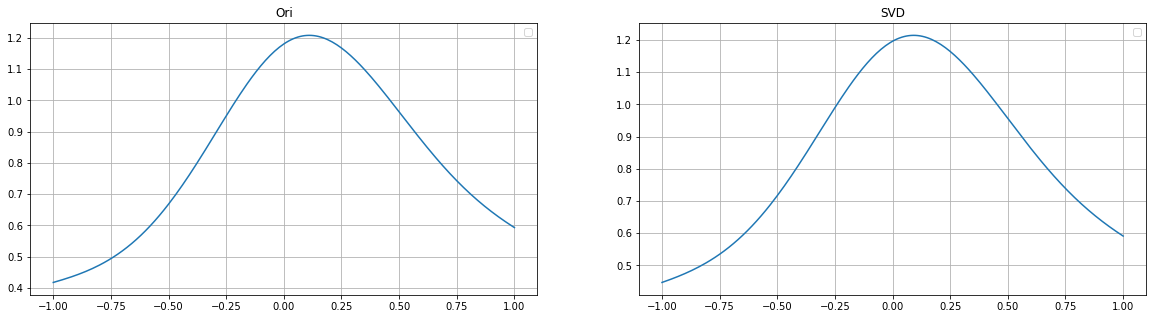

In [20]:
fig, ax = plt.subplots(1,2)
j = 0
for STKtype in ['Ori', 'SVD']:
    ax[j].set_title(STKtype)
    ax[j].plot(timeaxis,XcorrS[STKtype])
    ax[j].grid('on')
    ax[j].legend( )
    j += 1
fig.set_size_inches(20,5)

### MI

In [21]:
tv = ndimage.gaussian_filter1d(LPOU, order=1, sigma=1)/dt
#assign states
state_num = 6
xstate = EqualState(LPOU, state_num)[0]
tvstate = EqualState(tv, state_num)[0]

rstates = {}
for STKtype in ['Ori',  'SVD']:
    rstates[STKtype] = SG(Responses[STKtype][0], dt, 0, 2, 10)

In [22]:
MIs = {}
for STKtype in ['Ori', 'SVD']:
    timeshift, MIs[STKtype] = MIfunc(rstates[STKtype], xstate, dt, window)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


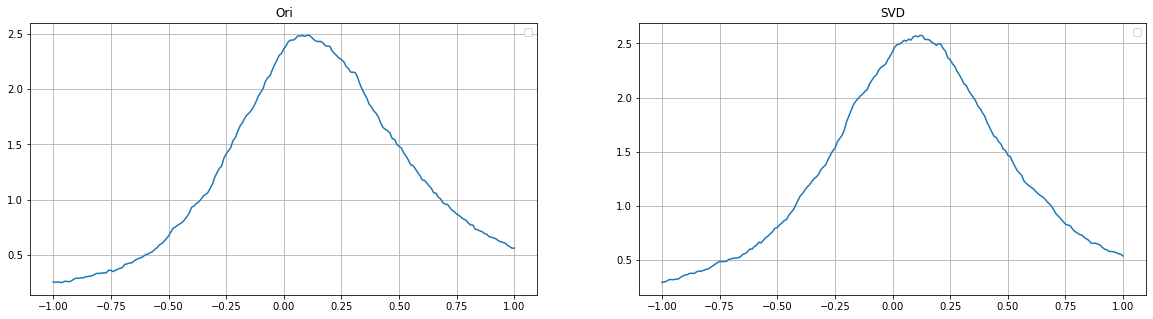

In [23]:
fig, ax = plt.subplots(1,2)
j = 0
for STKtype in ['Ori','SVD']:
    ax[j].plot(timeaxis, MIs[STKtype])#, label = r'$f_c=$'+str(Fc_list[i])+' Hz')
    ax[j].set_title(STKtype)
    ax[j].legend()
    ax[j].grid('on')
    j += 1
fig.set_size_inches(20,5)

## With Gain

In [24]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

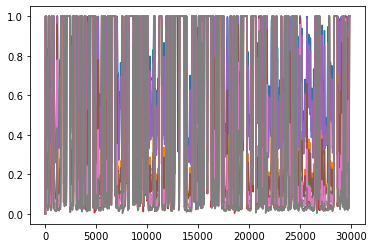

In [25]:
B = 150  #To tune altitude of gain control (D=1/T)
tau = 0.1

# Gains = {}
for STKtype in ['Ori', 'SVD']:
    Responses[STKtype+'+GC'] = [0]*len(mean_list)
    # Gains[STKtype] = [0]*len(LPOU_list)
    for i in range(len(mean_list)):  
        Responses[STKtype+'+GC'][i], gain = AddGainControl(Responses[STKtype][i], B, tau)
        plt.plot(gain) # make sure the value of gain is good

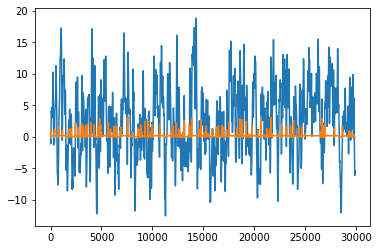

In [26]:
plt.plot(Responses['Ori'][-1])
plt.plot(Responses['Ori+GC'][-1])

(15000.0, 16000.0)

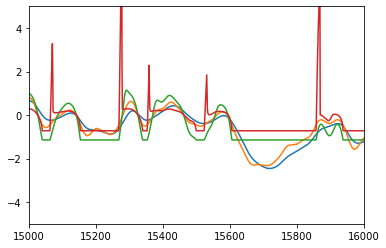

In [27]:
def CenterNormal(x):
    return (x-np.mean(x))/np.std(x)

plt.plot(CenterNormal(LPOU))
plt.plot(CenterNormal(Responses['Ori'][0]))
plt.plot(CenterNormal(Responses['Ori+GC'][0]))
plt.plot(CenterNormal(Responses['Ori+GC'][-1]))
plt.ylim(-5,5)
plt.xlim(15000,16000)

### STA

In [28]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

theta_star = 0
for STKtype in ['Ori+GC', 'SVD+GC']:
    XcorrS[STKtype] = []
    x = np.array(LPOU)
    x = (x-np.mean(x))/np.std(x)
    for i in range(len(mean_list)):


        r = Responses[STKtype][i]
        r = NL(r, np.mean(r)+theta_star*np.std(r))
        Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
        Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
        XcorrS[STKtype].append( Xcorr.copy() )

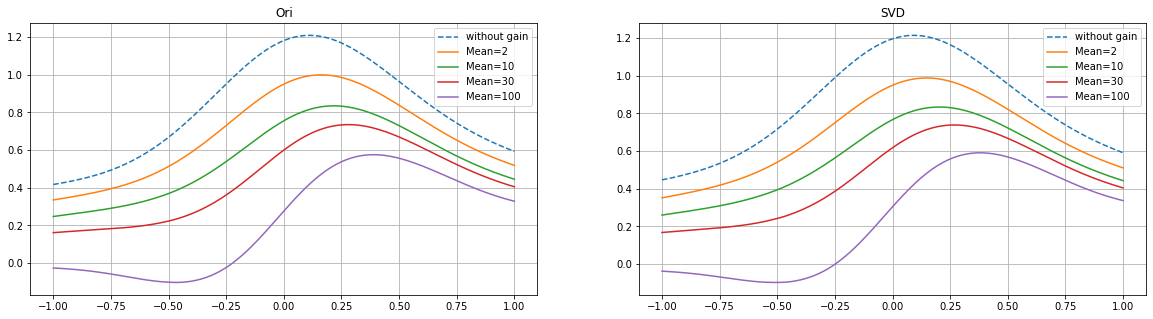

In [29]:
fig, ax = plt.subplots(1,2)
j = 0
for STKtype in ['Ori', 'SVD']:
    ax.flatten()[j].plot(timeaxis,XcorrS[STKtype], label= 'without gain', linestyle= 'dashed' )
    for i in range(len(mean_list)):  
        ax.flatten()[j].plot(timeaxis,XcorrS[STKtype+'+GC'][i], label = 'Mean='+str(mean_list[i]))
    ax.flatten()[j].legend()
    ax.flatten()[j].set_title(STKtype)
    ax.flatten()[j].grid('on')
    j += 1
fig.set_size_inches(20,5)

### MI

In [30]:
for STKtype in ['Ori+GC', 'SVD+GC']:
    rstates[STKtype] = [SG(r, dt, 0, 2, 10) for r in Responses[STKtype]]

In [31]:
for STKtype in ['Ori+GC', 'SVD+GC']:
    MIs[STKtype] = [0]*len(mean_list)
    for i in range(len(mean_list)):
        timeshift, MIs[STKtype][i] = MIfunc(rstates[STKtype][i], xstate, dt, window)

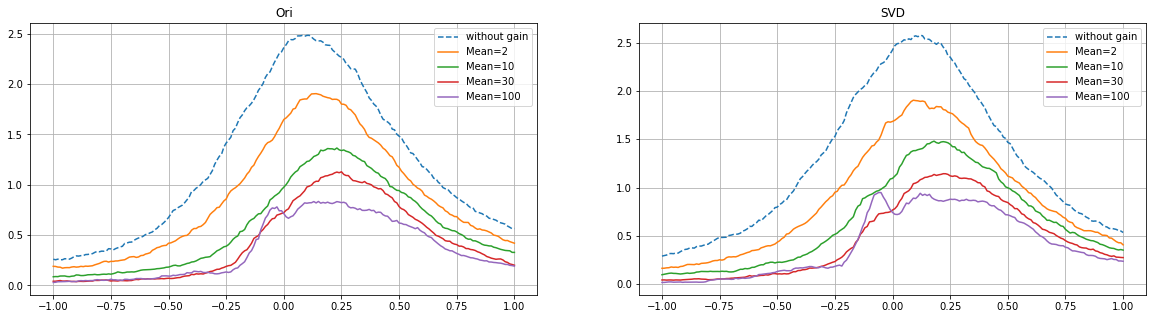

In [32]:
fig, ax = plt.subplots(1,2)
j = 0
for STKtype in ['Ori', 'SVD']:
    ax.flatten()[j].plot(timeaxis,MIs[STKtype], label= 'without gain', linestyle= 'dashed' )
    for i in range(len(mean_list)):  
        ax.flatten()[j].plot(timeaxis,MIs[STKtype+'+GC'][i], label = 'Mean='+str(mean_list[i]))
    ax.flatten()[j].set_title(STKtype)
    ax.flatten()[j].legend()
    ax.flatten()[j].grid('on')
    j+=1
fig.set_size_inches(20,5)